# Training MixtureOfSVGPExperts on the Motorcycle Data Set (with two experts)

This notebook is a basic example of configuring and training a Mixture of Gaussian Process Experts (using MixtureOfSVGPExperts) on the motorcycle dataset with two experts. Instantiating the model with two experts is a special case because only a single gating function is needed (not two!) and the gating network can be calculated in closed form, which is not the case when using more than two experts. 

In [10]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from gpflow import default_float
from gpflow.utilities import print_summary

from mogpe.experts import SVGPExperts, SVGPExpert
from mogpe.gating_networks import SVGPGatingFunction, SVGPGatingNetworkBinary
from mogpe.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.training import training_tf_loop
from mogpe.helpers.plotter import Plotter1D

Let's start by configuring some of the model and training parameters.

In [11]:
num_inducing = 7
batch_size = 30
logging_epoch_freq = 100
num_epochs = 5000

Load the motorcycle dataset and plot it to see what we're dealing with.

In [12]:
def load_mcycle_dataset(filename='../data/mcycle.csv'):
    df = pd.read_csv(filename, sep=',')
    X = pd.to_numeric(df['times']).to_numpy().reshape(-1, 1)
    Y = pd.to_numeric(df['accel']).to_numpy().reshape(-1, 1)

    X = tf.convert_to_tensor(X, dtype=default_float())
    Y = tf.convert_to_tensor(Y, dtype=default_float())
    print("Input data shape: ", X.shape)
    print("Output data shape: ", Y.shape)

    # standardise input
    mean_x, var_x = tf.nn.moments(X, axes=[0])
    mean_y, var_y = tf.nn.moments(Y, axes=[0])
    X = (X - mean_x) / tf.sqrt(var_x)
    Y = (Y - mean_y) / tf.sqrt(var_y)
    data = (X, Y)
    return data

Input data shape:  (133, 1)
Output data shape:  (133, 1)


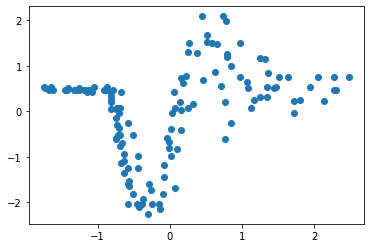

In [13]:
data_file = '../data/mcycle.csv'
dataset = load_mcycle_dataset(filename=data_file)
X, Y = dataset
num_data = X.shape[0]
input_dim = X.shape[1]
output_dim = Y.shape[1]
plt.scatter(X, Y)

In order to initialie the MixtureOfSVGPExperts class for two experts we must pass it an instance of SVGPExperts and an instance of SVGPGatingNetworkBinary. Let's start by creating an instance of SVGPExperts. To do this we must first create two SVGPExpert instances and pass them as a list to SVGPExperts. Let's create out first expert. 

In [14]:
noise_var_1 = 0.9
kern_var_1 = 2.
lengthscale_1 = 0.5

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_1)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale_1 = tf.convert_to_tensor([lengthscale_1] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_1))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_1 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)

And now our second expert with a longer lengthscale and lower noise.

In [15]:
noise_var_2 = 0.0011
kern_var_2 = 0.1
lengthscale_2 = 10.

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_2)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale_2 = tf.convert_to_tensor([lengthscale_2] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_2))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_2 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)


We can now create an instance of SVGPExperts by passing our two experts as a list.

In [16]:
experts_list = [expert_1, expert_2]
experts = SVGPExperts(experts_list)
print_summary(experts)

╒═══════════════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════╕
│ name                                                              │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value            │
╞═══════════════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════╡
│ SVGPExperts.experts_list[0].mean_function.c                       │ Parameter │ Identity         │         │ True        │ (1,)      │ float64 │ [0.]             │
├───────────────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────┤
│ SVGPExperts.experts_list[0].kernel.kernels[0].variance            │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 1.0              │
├───

Lovely stuff. We now need to create an instance of SVGPGatingNetworkBinary which requires an instance of SVGPGatingFunction (a single gating function) for its construction. Remember that we only need a single gating function for the two expert case. Let's go ahead and create our gating function and use it to construct our gating network.

In [17]:
idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)

inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

lengthscale = 1.
mean_function = gpf.mean_functions.Zero()

q_mu = np.zeros((num_inducing, output_dim)) + np.random.randn(num_inducing, output_dim) * 2
q_sqrt = np.array([
    10 * np.eye(num_inducing, dtype=default_float())
    for _ in range(output_dim)
])

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale = tf.convert_to_tensor([lengthscale] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale))
kernel = gpf.kernels.SeparateIndependent(kern_list)

gating_function = SVGPGatingFunction(kernel,
                                     inducing_variable,
                                     mean_function,
                                     q_mu=q_mu,
                                     q_sqrt=q_sqrt)
gating_network = SVGPGatingNetworkBinary(gating_function)
print_summary(gating_network)

╒═══════════════════════════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤═══════════════════╕
│ name                                                                                  │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value             │
╞═══════════════════════════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪═══════════════════╡
│ SVGPGatingNetworkBinary.gating_function_list[0].kernel.kernels[0].variance            │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 1.0               │
├───────────────────────────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼───────────────────┤
│ SVGPGatingNetworkBinary.gating_function_list[0].kernel.kernels[0].lengths

We now have all the components to construct our MixtureOfSVGPExperts model so let's go ahead and do it.

In [18]:
model = MixtureOfSVGPExperts(gating_network=gating_network, experts=experts, num_data=num_data)

We can use the Plotter1D class from `mogpe.helpers.plotter` to plot our model before training.

Plotting gating network mixing probabilities...
Plotting experts y...
Plotting y...
mixing probs shape
(100, 1, 2)
experts dists shape
(100, 1, 2)


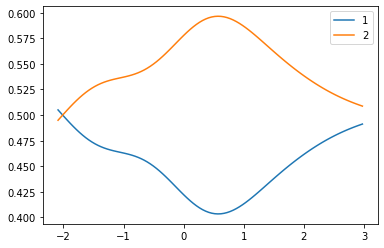

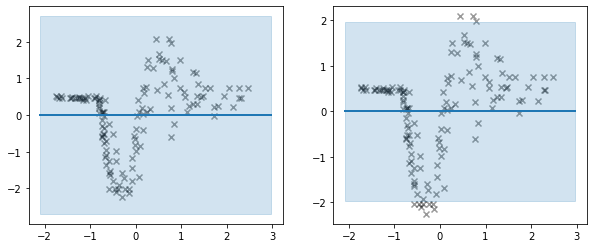

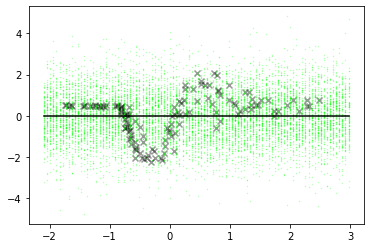

In [19]:
plotter = Plotter1D(model, X, Y)
plotter.plot_model()

We must now convert our numpy data set into a TensorFlow data set and set it up for stochastic optimisation by setting the batch size. We set drop_remainder=True to ensure the model receives the batch size.

In [20]:
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_data // 2
num_batches_per_epoch = num_data // batch_size
train_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = (train_dataset.repeat().prefetch(prefetch_size).shuffle(
    buffer_size=shuffle_buffer_size).batch(batch_size, drop_remainder=True))

We then use GPflows training_loss_closure method to get our training loss.

In [21]:
training_loss = model.training_loss_closure(iter(train_dataset))

In mogpe.training.training_loops some training loops are defined. Here we use the simple training_tf_loop which runs the Adam optimizer on model with training_loss as the objective function. The loop does not use any TensorBoard monitoring.

In [22]:
training_tf_loop(model,
                 training_loss,
                 epochs=num_epochs,
                 num_batches_per_epoch=num_batches_per_epoch,
                 logging_epoch_freq=logging_epoch_freq)

Instructions for updating:
Use fn_output_signature instead
Mixing probs
(30, 1, 2)
Expected experts
(30, 1, 2)
Experts after product over output dims
(30, 1, 2)
Marginalised indicator variable
(30,)
Reduced sum over mini batch
()
Epoch 100: ELBO (train) 517.7055176316156
Epoch 200: ELBO (train) 368.3874535025927
Epoch 300: ELBO (train) 385.8619662703743
Epoch 400: ELBO (train) 252.62874199093412
Epoch 500: ELBO (train) 293.9423343294689
Epoch 600: ELBO (train) 224.2919566507974
Epoch 700: ELBO (train) 255.01319616905099
Epoch 800: ELBO (train) 249.97830691007647
Epoch 900: ELBO (train) 208.9956295989463
Epoch 1000: ELBO (train) 221.94388831462007
Epoch 1100: ELBO (train) 143.98488438869484
Epoch 1200: ELBO (train) 179.2555397610626
Epoch 1300: ELBO (train) 39.677720390436825
Epoch 1400: ELBO (train) 163.5427979039727
Epoch 1500: ELBO (train) 57.41721816158085
Epoch 1600: ELBO (train) 110.68200509221698
Epoch 1700: ELBO (train) 91.53751638630843
Epoch 1800: ELBO (train) 51.9192612610901

Now that we have trained the model we can use our plotter again to visualise what we have learned.

Plotting gating network mixing probabilities...
Plotting experts y...
Plotting y...
mixing probs shape
(100, 1, 2)
experts dists shape
(100, 1, 2)


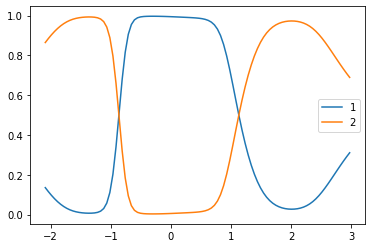

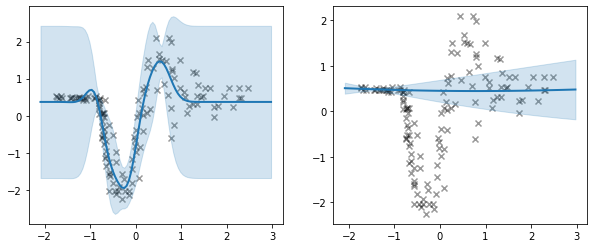

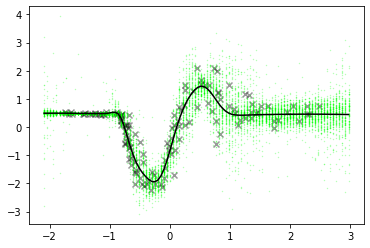

In [23]:
plotter.plot_model()